In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


Data preprocessing

In [3]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 120, 120, 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BASE_PATH = "garbage_classification/"
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery', 6: 'clothes', 7: 'glass'}
batch_size = 16

In [4]:
filenames, categories_list = [], []
for category_id, category_name in categories.items():
    category_path = os.path.join(BASE_PATH, category_name)
    category_filenames = [os.path.join(category_name, filename) for filename in os.listdir(category_path)]
    filenames.extend(category_filenames)
    categories_list.extend([category_id] * len(category_filenames))
df = pd.DataFrame({'filename': filenames, 'category': categories_list}).sample(frac=1).reset_index(drop=True)


In [5]:
df["category"] = df["category"].replace(categories) 

Data vizualization

metal\metal524.jpg


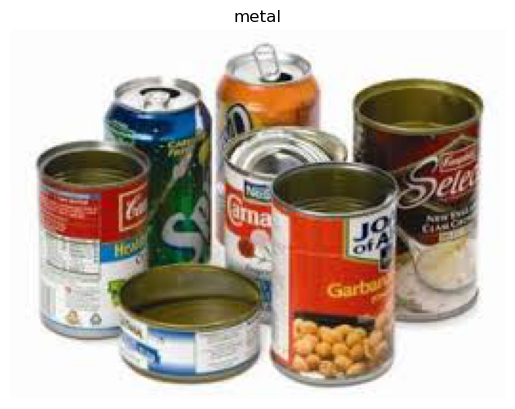

In [7]:
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]


random_image_path = BASE_PATH.rstrip('/') + '/' + sample['filename']
random_image = load_img(random_image_path)

print(sample['filename'])
plt.imshow(random_image)
plt.axis('off')  

plt.title(sample['category'])  
plt.show()

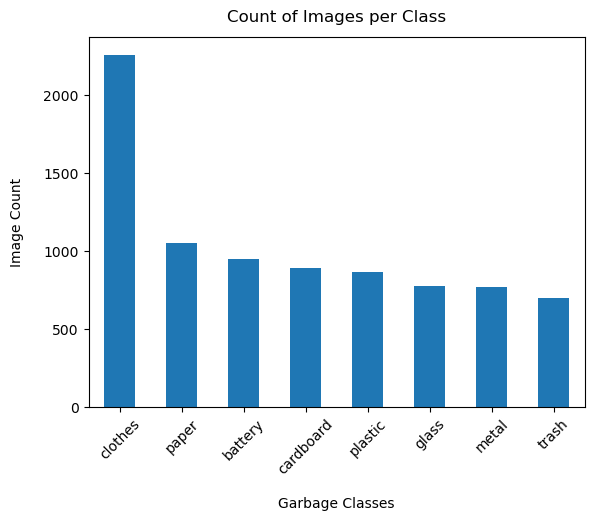

In [9]:
df_visualization = df.copy()

df_visualization['category'].value_counts().plot.bar()
plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Image Count", labelpad=14)
plt.title("Count of Images per Class", y=1.02)
plt.xticks(rotation=45)  
plt.show()  

In [10]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    BASE_PATH, 
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=IMAGE_SIZE, 
                                                    class_mode='categorical',
                                                    batch_size=batch_size)
validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
                                                              BASE_PATH,
                                                              x_col='filename', 
                                                              y_col='category', 
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical', 
                                                              batch_size=batch_size)


In [15]:
xception_layer = tf.keras.applications.Xception(include_top=False, 
                                                weights='imagenet', 
                                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
xception_layer.trainable = False

model = tf.keras.Sequential([
    xception_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 20,877,872
Trainable params: 16,392
Non-trainable params: 20,861,480
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(patience=2, verbose=1, monitor='val_accuracy', mode='max', min_delta=0.001, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
callbacks = [early_stop, model_checkpoint]

In [17]:
model.fit(train_generator, epochs=10, validation_data=validation_generator, 
          validation_steps=len(validate_df) // batch_size, 
          steps_per_epoch=len(train_df) // batch_size, 
          callbacks=callbacks)

Epoch 1/10
360/360 [==============================] - 199s 532ms/step - loss: 0.6109 - categorical_accuracy: 0.7963 - val_loss: 0.4585 - val_categorical_accuracy: 0.8571
Epoch 2/10
360/360 [==============================] - 163s 454ms/step - loss: 0.3280 - categorical_accuracy: 0.8970 - val_loss: 0.4142 - val_categorical_accuracy: 0.8693
Epoch 3/10
360/360 [==============================] - 110s 307ms/step - loss: 0.2508 - categorical_accuracy: 0.9259 - val_loss: 0.3952 - val_categorical_accuracy: 0.8693
Epoch 4/10
360/360 [==============================] - 107s 299ms/step - loss: 0.1969 - categorical_accuracy: 0.9434 - val_loss: 0.3937 - val_categorical_accuracy: 0.8750
Epoch 5/10
360/360 [==============================] - 108s 299ms/step - loss: 0.1574 - categorical_accuracy: 0.9594 - val_loss: 0.3858 - val_categorical_accuracy: 0.8864
Epoch 6/10
360/360 [==============================] - 109s 302ms/step - loss: 0.1326 - categorical_accuracy: 0.9674 - val_loss: 0.3871 - val_categoric

In [18]:
model.save_weights("model.h5")

In [19]:
model.save('my_model.h5')

In [20]:
import joblib 
joblib.dump(model, 'final_model.pkl')

INFO:tensorflow:Assets written to: ram://762a71e3-539c-403c-bb2a-39497079264a/assets


INFO:tensorflow:Assets written to: ram://762a71e3-539c-403c-bb2a-39497079264a/assets


['final_model.pkl']

In [22]:
test_datagen =ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=BASE_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1238 validated image filenames belonging to 8 classes.


In [25]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'cardboard', 2: 'clothes', 3: 'glass', 4: 'metal', 5: 'paper', 6: 'plastic', 7: 'trash'}


In [31]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming test_generator is your test data generator
# and it has the true labels encoded as integers

# Predict the output
preds = model.predict(test_generator)
predicted_classes = np.argmax(preds, axis=1)

# Get true labels
if hasattr(test_generator, 'classes'):
    true_classes = test_generator.classes
else:
    # Handle the case where test_generator does not have 'classes' attribute
    true_classes = []  # You'll need to populate this with the true labels manually

# Assuming you have a mapping of class indices to class labels
label_map = {v: k for k, v in test_generator.class_indices.items()}
predicted_labels = [label_map[k] for k in predicted_classes]

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=list(label_map.values())))


1238/1238 [==============================] - 108s 87ms/step
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       150
   cardboard       0.00      0.00      0.00       143
     clothes       0.14      0.08      0.10       342
       glass       0.00      0.00      0.00       112
       metal       0.00      0.00      0.00       120
       paper       0.00      0.00      0.00       148
     plastic       0.09      0.86      0.17       114
       trash       0.00      0.00      0.00       109

    accuracy                           0.10      1238
   macro avg       0.03      0.12      0.03      1238
weighted avg       0.05      0.10      0.04      1238



C:\Users\HP\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:

loss, accuracy = model.evaluate(test_generator)

# Print accuracy
print('Accuracy on test set = ', round((accuracy * 100), 2), '%')


1238/1238 [==============================] - 107s 86ms/step - loss: 138.4450 - categorical_accuracy: 0.1002
Accuracy on test set =  10.02 %
